<a href="https://colab.research.google.com/github/reissaavedra/mlops-titanic/blob/main/notebooks/model_evaluation_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpret Models with SHAP

## Imports

In [ ]:
!pip install shap
!pip install seaborn

In [3]:
%matplotlib inline 

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import shap
shap.initjs()

**Advertencia**
Si va a ejecutar el siguiente notebook, cargar los archivos csv y los modelos, en la carpeta data y models respectivamente

## Loading Data

In [4]:
X_train = pd.read_csv('data/feature_train.csv', index_col=0)
y_train = pd.read_csv('data/label_train.csv', index_col=0)
X_valid = pd.read_csv('data/feature_valid.csv', index_col=0)
y_valid = pd.read_csv('data/label_valid.csv', index_col=0)

In [5]:
FEATURES=list(X_train.columns)
LABEL='survived'
df=pd.concat([X_train,y_train], axis=1)
df.shape

(712, 33)

Generamos una matriz de correlación

<Axes: >

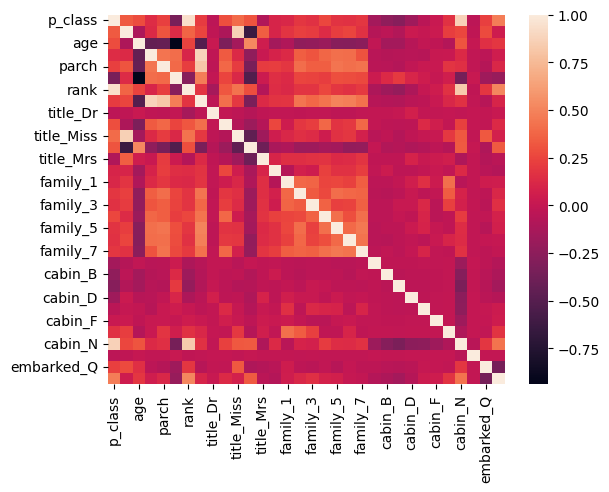

In [7]:
corr = X_train.corr()
sns.heatmap(corr)

## Load model

In [8]:
import joblib
xg_boost_clasifier = joblib.load('models/xg_boost_model.joblib')
logistic_regression = joblib.load('models/logistic_regression_model.joblib')
random_forest = joblib.load('models/rf_model.joblib')

## Explain model
###Metodología:
Tenemos 2 modelos que fueron entrenados usando el mismo dataset: xg_boost_clasifier y logistic_regression.


## XgBoostClasifier
Para analizar el model xgBoost, usaremos shap.kmeans para generar ´k´ puntos céntricos(centroides) dentro del dataset.
Estos puntos nos permitirán:
- "Resumir" el dataset. Se generará una representación del dataset y nos dará un indicio ya de las features más relevantes.
- Reducir el tiempo el análisis

Para este caso en particular usaremos Kernel Explainer:
- Funciona con cualquier ML framework(ideal para XgBoost, ya que TreeExplainer aun no lo soporta).
- Usa como inputs las features y los valores predecidos.


In [9]:
# En este caso: k=20
df_train_summary = shap.kmeans(X_train.values, 20)

explainer_xgboost = shap.KernelExplainer(xg_boost_clasifier.predict, df_train_summary)

shap_values_xgboost = explainer_xgboost.shap_values(X_train.values)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


  0%|          | 0/712 [00:00<?, ?it/s]

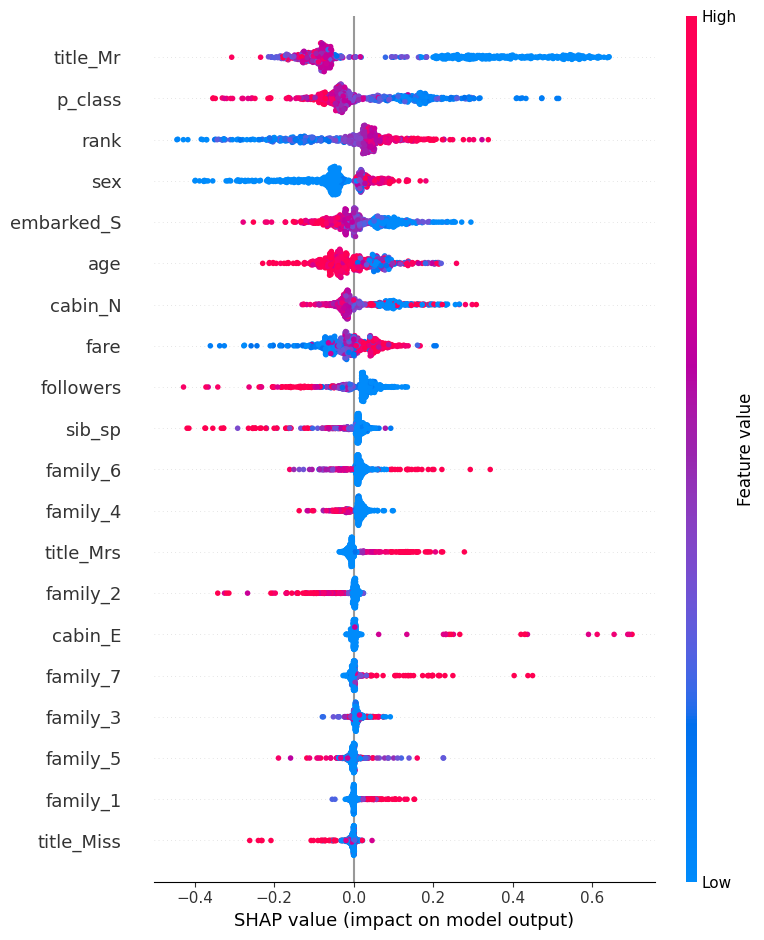

In [11]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values_xgboost, X_train)

Visualizando esta imagen, vemos que las clases más importantes son **title_Mr**, p_class, rank y sex.
Vayamos un poco más a fondo: el modelo encontró que para el caso de **title_Mr**(que indica 1 si el pasajero tiene el título de Mr en el nombre, mientras que 0 si no lo tiene), el no tener este título impacta positivamente dentro del output del modelo, mientras que tenerlo impacta negativamente en este output.
Pero, ¿qué quiere decir esto? si un pasajero tiene el título de Mr en su nombre (que indica que es un señor de mediana a edad mayor), el modelo encontró que es un indicativo de no haber sobrevivido, mientras que no tenerlo aumenta las probabilidades de haber sobrevivido.

Analizando las siguientes clases, podemos ver que ocurre algo peculiar: si el pasajero tiene la feature **p_class** en un nivel bajo(indicativo que pertenece a primera clase), tiene más probabilidades de haber sobrevivido, a diferencia que tener un nivel **p_class** alto(2da clase o 3ra clase), donde sea el caso, esto aumenta las probabilidades de no sobrevivir.

Siguiendo con el análisis, tenemos una feature similar: **rank**. Esta clase lo que indica es, de acuerdo al título, un rango normal o alto(e.g. una persona con el título de Mr tiene un rango normal, mientras que alguien con el título de doctor tiene un rango alto).
**1 si tiene un rango normal, y 0 si tiene un rango alto**
El modelo nos dice, que aquellos que tener un rango alto, disminuye las posibilidades de sobrevivir, mientras que tener un rango normal, las aumenta.

Para finalizar tenemos el feature **sex**. 
**1 si es mujer, y 0 si es varón**
El modelo nos indica, que ser mujer impacta positivamente en nuestro output, mientras que ser varón lo reduce.

A continuación, vamos a ver un ejemplo: 
Veamos un pasajero con los siguientes datos
- **passenger_id** 330
- **p_class** 1
- **name** Hippach, Miss. Jean Gertrude    
- **sex** female  
- **age** 16.0 
- **sib_sp** 0 
- **parch** 1 
- **fare** 57.9792
- **cabin** B18
- **embarked** C
                                


In [44]:
X_train_with_idx = pd.read_csv('data/feature_train.csv')
x = X_train_with_idx[X_train_with_idx['Unnamed: 0'] == 330]
x

,Unnamed: 0,p_class,sex,age,sib_sp,parch,fare,rank,followers,title_Dr,...,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_N,cabin_T,embarked_Q,embarked_S
517,330,0.016601,0.016601,0.265614,0.0,0.016601,0.962506,0.016601,0.016601,0.0,...,0.016601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


De acuerdo al modelo, esta señorita cumplía con los requisitos para sobrevivir:
- No tenía title_Mr: Tenía el title Miss
- Primera clase
- sex femenino
- Edad baja: tiene 16 años

Sin embargo, el valor arrojado por rank, es bajo, por lo cual podríamos estar cometiendo un error en como definimos esta clase.
A futuro podríamos considerar redefinirla, o retirarla, debido a que está generando ruido dentro del modelo, y no está representando lo que debería

In [45]:
shap.initjs()
INSTANCE_NUM = 517
shap.force_plot(explainer_xgboost.expected_value, shap_values_xgboost[INSTANCE_NUM], X_train.iloc[INSTANCE_NUM,:])

Ahora veamos como interactúan las clases para generar un impacto dentro del modelo. Empecemos viendo la interacción de age con sex features.

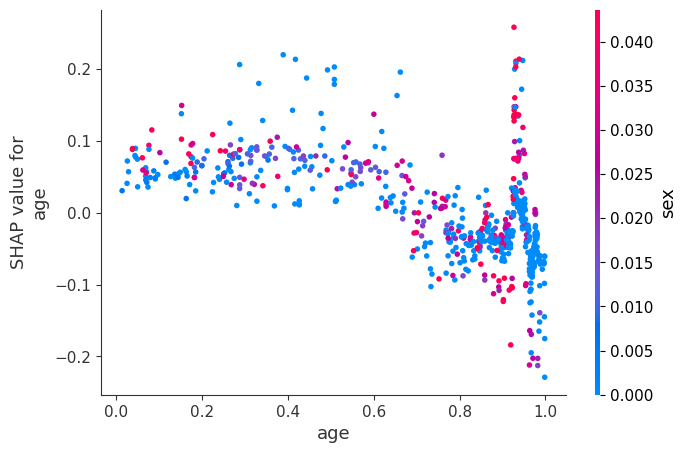

In [49]:
shap.dependence_plot('age', shap_values_xgboost, X_train, interaction_index='sex')

Aquí podemos observar algo sumamente interesante:
A medida que el rango de edad de edad aumenta, el valor de impacto de la clase sex va cambiando: si el pasajero es joven(**age**< 0.5 approx.), podemos ver que el valor de **sex** no es tan relevante para el impacto del modelo, ya que todos impactan positivamente, pero a medida que el valor de **age** aumenta, podemos ver que ser varón(**sex**=0) impacta negativamente en el output del modelo

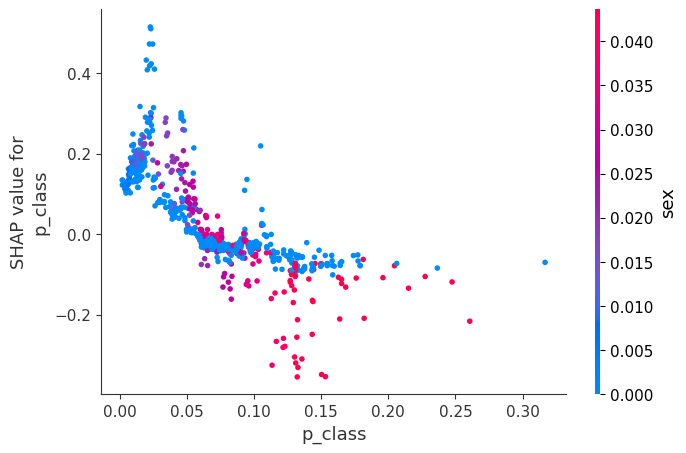

In [52]:
shap.dependence_plot('p_class', shap_values_xgboost, X_train, interaction_index='sex')

Aquí podemos ver otro caso curioso de interacción de variables:
Mientras más bajo sea el valor de p_class(primera clase), es indistinto el valor de sex: ambos aportan positivamente al output del modelo.
Sin embargo a medida que el valor de p_class aumenta(segunda y tercera clase), se va volviendo indistinta esta característica(empienzan a aportar negativamente al output del modelo).

## Conclusiones
- Respecto al modelo podemos ver que el modelo ha logrado aprender cosas interesantes, sin embargo considero que podríamos mejorarlo realizando ciertas modificaciones dentro del feature pipeline(removería la feature rank, y podría realizar one hot encoding sobre la clase p_class)
- También podemos observar que el modelo ha podido aprender la política vigente de aquella época: 'Niños y mujeres primero', lo cual lo vemos reflejado en la selección de las caracteŕisticas más relevantes(exceptuando rank)